# Цели и задачи проекта

### Основная цель проекта - на основе датасета stud_math.csv оценить, какие условия жизни учащихся влияют на их успеваемость по математике.

### Задачи:

#### Оценить и очистить данные. Удалить очевидные ошибки и выбросы данных.

#### Провести корреляционный анализ числовых данных.

#### Провести анализ нечисловых данных. Выявить значимые данные для дальнейшего анализа

#### Подготовить датасет для дальнейшего построения модели.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import re

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

df = pd.read_csv('stud_math.csv')

In [2]:
'''Функции для обработки строк.'''


def hist_eject(column):
    '''Строит гистограмму числового столбца с выделенными выбросами.'''

    series = df[column]

    b = 16
    median = series.median()
    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    IQR = q75 - q25

    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1, 1])

    axes.hist(series.loc[series.between(q25 - 1.5*IQR, q75 + 1.5*IQR)], bins=b,
              range=(series.min()-1, series.max()+1), label='included', color='grey')
    axes.hist(series.loc[(series < q25 - 1.5*IQR) | (series > q75 + 1.5*IQR)], bins=b,
              range=(series.min()-1, series.max()+1), label='ejections', color='deeppink')

    axes.set_title(column)

    plt.axvline(q25 - 1.5*IQR, label='min = ' +
                str(q25 - 1.5*IQR), c='mediumblue')
    plt.axvline(q25, label='Q1 = '+str(q25), c='gold')
    plt.axvline(median, label='Q2 = '+str(median), c='k')
    plt.axvline(q75, label='Q3 = '+str(q75), c='green')
    plt.axvline(q75 + 1.5*IQR, label='max = ' +
                str(q75 + 1.5*IQR), c='darkorange')

    plt.legend()
    return


def del_eject(series):
    '''Убирает выбросы из числового столбца.'''

    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    IQR = q75 - q25
    series = series.apply(lambda x: None if (
        x < q25 - 1.5*IQR) or (x > q75 + 1.5*IQR) else x)
    return series


def get_boxplot(column):
    '''Коробочные диаграммы для нечисловых величин.'''
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(column):
    '''Поиск статистически значимых различий для колонки с помощью теста Стьюдента.'''
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

# Первичный анализ данных в столбцах

In [3]:
display(df.sample(10))
display(df.info())

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
215     GP   F   17       U     LE3       T   3.0   2.0     other     other   
124     GP   F   16       U     GT3       T   2.0   2.0     other     other   
97      GP   F   16       U     GT3       T   2.0   1.0     other     other   
82      GP   F   15       U     LE3       T   3.0   2.0  services     other   
216     GP   F   17       U     GT3       T   4.0   3.0     other       NaN   
332     GP   F   18       U     GT3       T   3.0   3.0  services  services   
261     GP   M   18       U     GT3       T   4.0   3.0   teacher     other   
340     GP   F   19       U     GT3       T   2.0   1.0  services  services   
278     GP   F   18       U     GT3       T   4.0   4.0    health    health   
77      GP   F   16       U     GT3       T   2.0   2.0     other     other   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
215  reputation   mother         2.0        2.0       0.0        no     no   
124        home   mother         1.0        2.0       0.0        no     no   
97       course   mother         1.0        2.0       0.0        no    yes   
82   reputation   mother         1.0        2.0       0.0        no    yes   
216  reputation   mother         1.0        2.0       2.0        no     no   
332        home   mother         1.0        2.0       0.0        no     no   
261      course   mother         NaN        2.0       NaN        no    yes   
340        home    other         1.0        3.0       1.0        no     no   
278  reputation   father         1.0        2.0       1.0       yes    yes   
77          NaN   mother         1.0        4.0       0.0        no     no   

    paid activities nursery  studytime, granular higher internet romantic  \
215  NaN         no     yes                 -6.0    yes      NaN       no   
124  yes         no     yes                 -6.0    yes      yes      yes   
97   yes         no     yes                 -6.0    yes       no      yes   
82   NaN         no     yes                 -6.0    yes      yes       no   
216  yes         no     yes                 -6.0    yes      yes      yes   
332   no        yes     NaN                 -6.0    yes      yes       no   
261  yes         no      no                 -6.0    yes      yes      NaN   
340  yes        yes     NaN                 -9.0    yes      NaN      yes   
278   no        yes     yes                 -6.0    yes      yes      yes   
77   yes         no     yes                -12.0    yes      yes      yes   

     famrel  freetime  goout  health  absences  score  
215     4.0       4.0    4.0     1.0       NaN   75.0  
124     5.0       4.0    4.0     5.0       0.0   40.0  
97      4.0       3.0    5.0     5.0       2.0   50.0  
82      4.0       4.0    4.0     5.0      10.0   30.0  
216     3.0       4.0    5.0     1.0      22.0   20.0  
332     5.0       3.0    4.0     4.0       0.0    0.0  
261     4.0       3.0    2.0     3.0       2.0   40.0  
340     4.0       3.0    4.0     3.0       4.0   55.0  
278     2.0       4.0    4.0     4.0      15.0   40.0  
77      5.0       2.0    3.0     3.0       0.0   55.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

None

#### В датасете 30 столбцов (13 числовых и 17 строковых) и 395 строк. 
#### Названия столбцов достаточно удобные, переименовывать не обязательно. 
#### Данные полные только для столбцов school, sex и age. Даже для критически значимого score не хватает 6 значений. Думаю, эти 6 строк можно удалить.

In [4]:
'''Удаляем строки, для которых нет score.'''

df = df.loc[df.score.notnull()]

50.0   55.0   0.0    75.0   65.0   40.0   60.0   70.0   45.0   80.0   \
score     54     46     37     33     31     31     31     27     27     16   

       30.0   90.0   35.0   25.0   85.0   95.0   100.0  20.0   
score     15     12      9      7      6      5      1      1

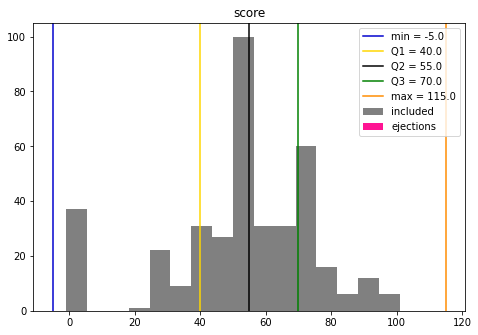

In [5]:
'''Заодно стоит проверить распределение значений score.'''

hist_eject('score')
pd.DataFrame(df.score.value_counts()).T

In [6]:
'''Как распределяются разности между ближайшими значениями.'''

deltas = []
a = sorted(df.score.unique())[0]
for b in sorted(df.score.unique())[1:]:
    deltas.append(b-a)
    a = b
pd.DataFrame(deltas).T

0    1    2    3    4    5    6    7    8    9   10   11   12   13   14  \
0  20.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0   

    15   16  
0  5.0  5.0

#### Почти все значения в столбце лежат в границах от 20 до 100 (основная группа). И помимо основной группы есть 37 значений равных нулю (группа нулей). Несмотря на то, что из-за достаточного большого разброса основной группы, группа нулей не попала в выбросы, всё же есть основания говорить о том, что это всё же выбросы. Об этом говорит то, что они не связаны с основной группой (разрыв между ближайшим значением - 20, тогда, как все остальные разрывы = 5). И здравый смысл подсказывает, что на экзамене очень сложно набрать 0 баллов. Скорее всего, это те, кто просто на экзамен не пришел. Поэтому, мне кажется логичным удалить эти данные из выборки.

In [7]:
df = df.loc[df.score > 0]

In [8]:
'''Названия 'studytime', 'studytime, granular' очень похожи, 
   посмотрим, как они соотносятся.'''

display(df[['studytime', 'studytime, granular']].corr())

studytime  studytime, granular
studytime                  1.0                 -1.0
studytime, granular       -1.0                  1.0

In [9]:
'''Похоже, "studytime, granular" - это "studytime", 
умноженный на отрицательную константу, так что его можно просто убрать.'''

df.drop(['studytime, granular'], inplace=True, axis=1)

In [10]:
'''Какие данные есть в строковых столбцах. 
   Заодно запишем названия числовых и строковых 
   столбцов в отдельные списки.'''

columns_num = []
columns_obj = []

for column in df.columns:
    if df[column].dtype == 'object':
        columns_obj.append(column)
        print(df[column].unique())
    else:
        columns_num.append(column)

['GP' 'MS']
['F' 'M']
['U' nan 'R']
[nan 'GT3' 'LE3']
['A' nan 'T']
['at_home' 'health' 'other' 'services' 'teacher' nan]
['teacher' 'other' nan 'health' 'services' 'at_home']
['course' 'other' 'home' 'reputation' nan]
['mother' 'father' 'other' nan]
['yes' 'no' nan]
['no' 'yes' nan]
['no' nan 'yes']
['no' 'yes' nan]
['yes' 'no' nan]
['yes' nan 'no']
[nan 'yes' 'no']
['no' nan 'yes']


#### Нестандартных значений в строковых столбцах нет. Преобразовывать нечего.
#### Уникальных значений в строковых столбцах немного. Так что нет особого смысла рассматривать подробно по-отдельности каждый столбец. И при составлении коробочной диаграммы можно, в принципе, использовать все уникальные значения.

In [11]:
'''Данные строковых столбцов.'''

for column in columns_obj:
    display(pd.DataFrame(df[column].value_counts()))

school
GP     311
MS      41

sex
F  182
M  170

address
U      265
R       73

famsize
GT3      228
LE3      100

Pstatus
T      277
A       34

Mjob
other      115
services    90
teacher     51
at_home     49
health      30

Fjob
other      176
services    89
teacher     26
health      15
at_home     14

reason
course         119
reputation      96
home            89
other           33

guardian
mother       225
father        78
other         20

schoolsup
no         295
yes         48

famsup
yes     196
no      120

paid
no    170
yes   146

activities
yes         172
no          168

nursery
yes      272
no        68

higher
yes     320
no       13

internet
yes       274
no         49

romantic
no        219
yes       104

### Среди значений строковых столбцов нет ни одного значения, который встечается меньше 13 раз, а учитывая относительно небольшой объем выборки (395) и то, что уникальных значений не бывает больше 5, это достаточно значимо.

In [12]:
'''Распределения числовых переменных.'''

display(df.describe())

age        Medu        Fedu  traveltime   studytime    failures  \
count  352.000000  350.000000  331.000000  329.000000  345.000000  332.000000   
mean    16.633523    2.811429    2.658610    1.428571    2.046377    0.271084   
std      1.256011    1.091192    2.324066    0.690907    0.840919    0.667779   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000    1.000000    1.000000    0.000000   
50%     17.000000    3.000000    3.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000   40.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout      health    absences       score  
count  328.000000  344.000000  346.000000  339.000000  342.000000  352.000000  
mean     3.942073    3.235465    3.086705    3.516224    8.090643   57.755682  
std      0.921871    1.004258    1.091998    1.412812   24.704600   16.200928  
min     -1.000000    1.000000    1.000000    1.000000    0.000000   20.000000  
25%      4.000000    3.000000    2.000000    3.000000    2.000000   45.000000  
50%      4.000000    3.000000    3.000000    4.000000    4.000000   55.000000  
75%      5.000000    4.000000    4.000000    5.000000    8.000000   70.000000  
max      5.000000    5.000000    5.000000    5.000000  385.000000  100.000000

#### Согласно описанию столбцов, ясно, что некоторые значения дискретны и имеют строгие границы возможных вариантов:  (age = [15 - 22];   Medu, Fedu = [0, 1, 2, 3, 4];   traveltime, studytime = [1, 2, 3, 4];   failures = [0, 1, 2, 3];   famrel, freetime, goout, health = [1 - 5]). Как видно из таблицы describe, не во всех столбцах min и max значения лежат в рамках границ. Это явные ошибки и их следует удалить из выборки.

In [13]:
'''Удаление очевидных ошибок.'''
df.Fedu = df.Fedu.apply(lambda x: None if (x > 4) else x)
df.famrel = df.famrel.apply(lambda x: None if (x < 1) else x)

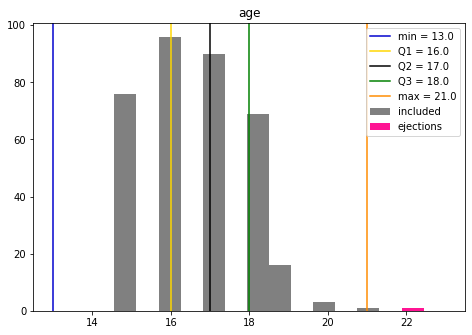

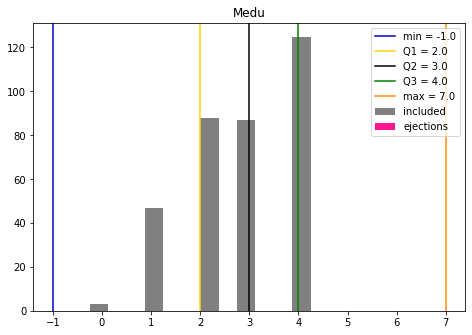

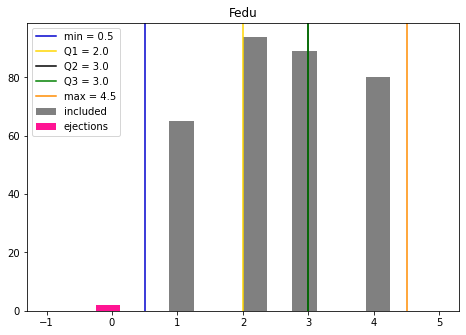

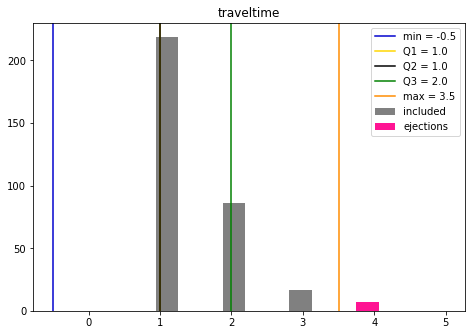

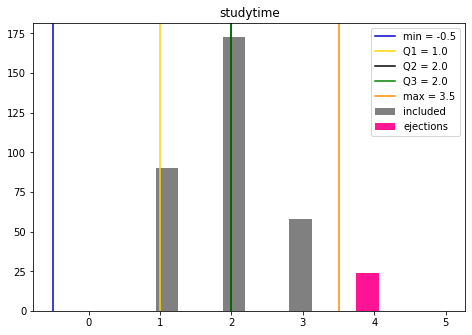

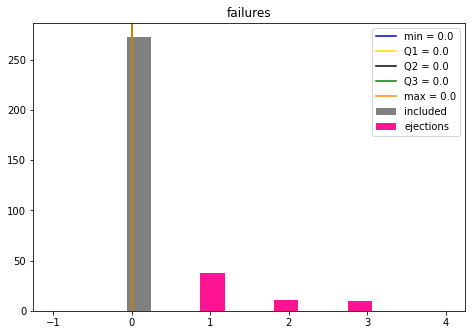

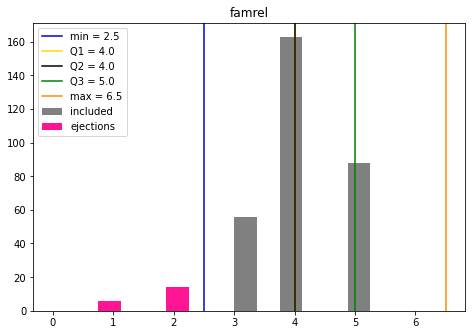

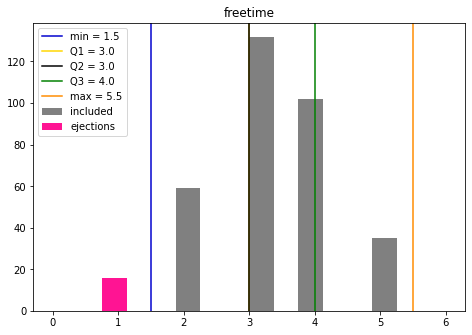

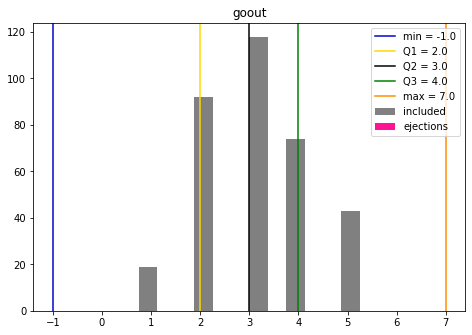

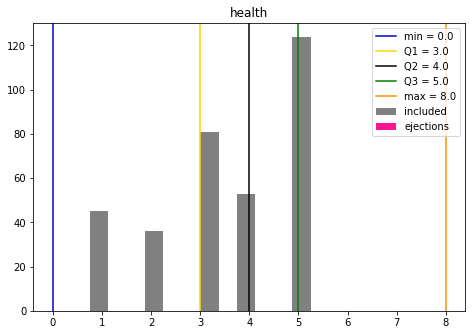

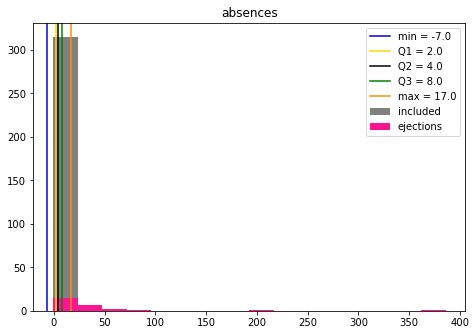

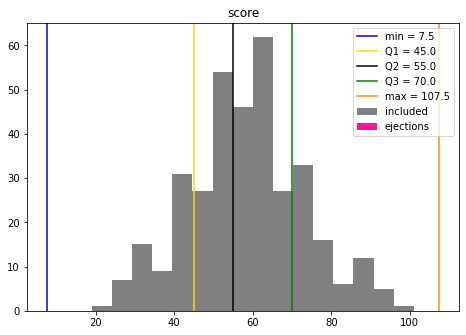

In [14]:
'''Гистограммы численных столбцов величин.'''

for column in columns_num:
    hist_eject(column)

In [15]:
for column in columns_num:
    display(pd.DataFrame(df[column].value_counts()).T)

16  17  15  18  19  20  22  21
age  96  90  76  69  16   3   1   1

4.0  2.0  3.0  1.0  0.0
Medu  125   88   87   47    3

2.0  3.0  4.0  1.0  0.0
Fedu   94   89   80   65    2

1.0  2.0  3.0  4.0
traveltime  219   86   17    7

2.0  1.0  3.0  4.0
studytime  173   90   58   24

0.0  1.0  2.0  3.0
failures  273   38   11   10

4.0  5.0  3.0  2.0  1.0
famrel  163   88   56   14    6

3.0  4.0  2.0  5.0  1.0
freetime  132  102   59   35   16

3.0  2.0  4.0  5.0  1.0
goout  118   92   74   43   19

5.0  3.0  4.0  1.0  2.0
health  124   81   53   45   36

0.0    2.0    4.0    6.0    8.0    10.0   12.0   14.0   3.0    \
absences     74     60     52     30     20     17     12     12      7   

          16.0   7.0    5.0    18.0   20.0   22.0   9.0    1.0    15.0   \
absences      7      6      5      5      4      3      3      3      2   

          13.0   11.0   25.0   54.0   385.0  26.0   56.0   24.0   212.0  \
absences      2      2      1      1      1      1      1      1      1   

          21.0   75.0   30.0   19.0   38.0   40.0   23.0   17.0   28.0   
absences      1      1      1      1      1      1      1      1      1

50.0   55.0   75.0   65.0   40.0   60.0   70.0   45.0   80.0   30.0   \
score     54     46     33     31     31     31     27     27     16     15   

       90.0   35.0   25.0   85.0   95.0   100.0  20.0   
score     12      9      7      6      5      1      1

#### Поскольку большая часть столбцов имеют дискретные значения, то выбросы, мне кажется, не всегда могут быть представлены адекватно.
#### - age (много студентов 16 лет, поэтому медиана и квартили сместились в меньшую сторону, всего по 1 ученику 21 и 22 года, но в выбросы попал только студент 22 лет, не думаю, что это принципиально важно)
#### - Fedu (много средне-образовынных отцов дают малое значение IQR, малообразованные остаются за рамками статистической значимости)
#### - traveltime (из-за того, что почти все живут в пешей доступности, то ученики, живущие очень далеко не вносят значимого статистического вклада, однако их примерно 2%, так что не вижу необходимости исключать их из выборки)
#### - studytime (из-за малого значения IQR ученики, которые много занимаются вне школы, остаются за рамками границ выбросов, однако в виду того, что уникальных значений мало, а вхождений значения 4 - достаточно много (24), я не вижу необходимости исключать их из выборки)
#### - failures (поскольку очень много значений 0 (<1 или >3 внеучебных неудач), все остальные значения выглядят как выбросы, однако именно они дают информацию об этом параметре; или нужно удалять весь столбец, или не удалять выбросы, или, возможно, смотреть только значения, отличные от 0; попробую посмотреть как есть)
#### - famrel (учеников с совсем плохими отношениями в семье довольно мало, но почти 2% от выборки, не вижу необходимости убирать их из выборки)
#### - freetime (из-за дискретности данных, нижний квартиль сравнялся с медианой, а IQR стал очень маленьким, поэтому расчеты показали выброс в нижней части, не вижу необходимости их удалять)
#### - absences (здесь есть явные стат отклонения - очень большие величины (около 200 и max в 385), они далеко в отрыве от основной группы, и ещё множество значений по 1 вхождению, сначала я удалю явные выбросы, а потом ещё раз посмотрю на гистограмму)

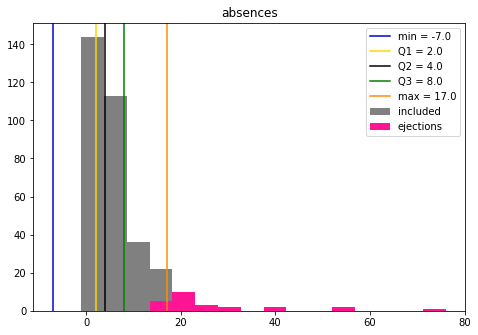

In [16]:
df.age = del_eject(df.age)
df.Fedu = del_eject(df.Fedu)
df.absences = df.absences.apply(lambda x: None if (x > 100) else x)
hist_eject('absences')

In [17]:
'''Поскольку после удаления двух явных выбросов, границы выбросов 
не изменились, то уберем и те одиночных вхождения за границами'''

df.absences = del_eject(df.absences)

In [18]:
'''Посмотрим, сколько пустых значений стало после удаления выбросов.'''
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      352 non-null    object 
 1   sex         352 non-null    object 
 2   age         351 non-null    float64
 3   address     338 non-null    object 
 4   famsize     328 non-null    object 
 5   Pstatus     311 non-null    object 
 6   Medu        350 non-null    float64
 7   Fedu        328 non-null    float64
 8   Mjob        335 non-null    object 
 9   Fjob        320 non-null    object 
 10  reason      337 non-null    object 
 11  guardian    323 non-null    object 
 12  traveltime  329 non-null    float64
 13  studytime   345 non-null    float64
 14  failures    332 non-null    float64
 15  schoolsup   343 non-null    object 
 16  famsup      316 non-null    object 
 17  paid        316 non-null    object 
 18  activities  340 non-null    object 
 19  nursery     340 non-null    o

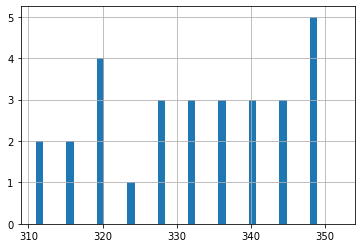

In [19]:
count_not_null = []
for column in df.columns:
    count_not_null.append(len(df[column].loc[df[column].notnull()]))
pd.Series(count_not_null).hist(bins = 10, width = 1)

#### Судя по распределению количества ненулевых значений в столбцах получившегося df, данные довольно полные. 

# Корреляционный анализ

age      Medu      Fedu  traveltime  studytime  failures  \
age         1.000000 -0.128496 -0.126251    0.106431   0.004173  0.193357   
Medu       -0.128496  1.000000  0.621917   -0.165394   0.070533 -0.205944   
Fedu       -0.126251  0.621917  1.000000   -0.147357   0.001263 -0.273576   
traveltime  0.106431 -0.165394 -0.147357    1.000000  -0.101490  0.091757   
studytime   0.004173  0.070533  0.001263   -0.101490   1.000000 -0.156406   
failures    0.193357 -0.205944 -0.273576    0.091757  -0.156406  1.000000   
famrel      0.055104 -0.013997 -0.036326   -0.036807   0.045260  0.035227   
freetime   -0.004895  0.021002 -0.021901   -0.023067  -0.128661  0.127391   
goout       0.105288  0.080556  0.041421    0.029374  -0.029686  0.126770   
health     -0.034894 -0.038050  0.001252   -0.000092  -0.085469  0.064083   
absences    0.164239  0.088397 -0.018083   -0.058051  -0.054918  0.177406   
score      -0.121579  0.186477  0.144600   -0.075516   0.142055 -0.289377   

              famrel  freetime     goout    health  absences     score  
age         0.055104 -0.004895  0.105288 -0.034894  0.164239 -0.121579  
Medu       -0.013997  0.021002  0.080556 -0.038050  0.088397  0.186477  
Fedu       -0.036326 -0.021901  0.041421  0.001252 -0.018083  0.144600  
traveltime -0.036807 -0.023067  0.029374 -0.000092 -0.058051 -0.075516  
studytime   0.045260 -0.128661 -0.029686 -0.085469 -0.054918  0.142055  
failures    0.035227  0.127391  0.126770  0.064083  0.177406 -0.289377  
famrel      1.000000  0.148843  0.035723  0.120631 -0.086868  0.030041  
freetime    0.148843  1.000000  0.296392  0.072729  0.086308 -0.012457  
goout       0.035723  0.296392  1.000000 -0.010343  0.167828 -0.182286  
health      0.120631  0.072729 -0.010343  1.000000 -0.033991 -0.075340  
absences   -0.086868  0.086308  0.167828 -0.033991  1.000000 -0.229627  
score       0.030041 -0.012457 -0.182286 -0.075340 -0.229627  1.000000

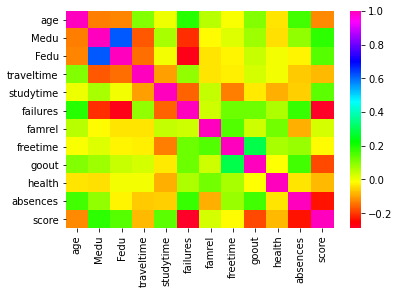

In [20]:
'''Корреляция величин.'''
correlation = df.corr()
display(correlation)
sns.heatmap(correlation, annot=False, cmap='gist_rainbow')

#### Из тепловой карты корреляции и таблицы сразу видно, что сильнее всего коррелируют уровни образования родителей (Medu и Fedu). Также достаточно сильная корреляция у количества свободного времени после школы (freetime) и проведенного времени с друзьями (goout), что достаточно логично.
#### Что касается корреляций непосредственно со столбцом score:  
#### failures (внеуч. неудачи), absences (пропуски занятий), goout (время с друзями) - наибольшая отрицательная 
#### Medu (образование мамы), Fedu (образование папы), studytime (время внеурочных занятий) - имеет наибольную в наборе положительную корреляцию (где-то 0.14 - 0.19)
#### Остальные также имеют корреляцию, но более слабую. Отрицательная: age (возраст), traveltime (время в пути), health (здоровье), freetime (свободное время), положительная: famrel (отношения в семье).

# Анализ нечисловых величин

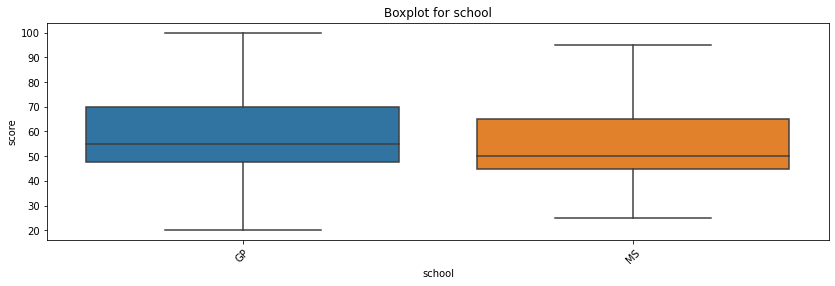

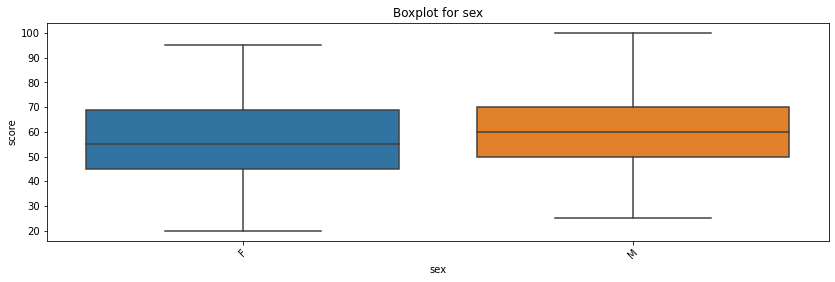

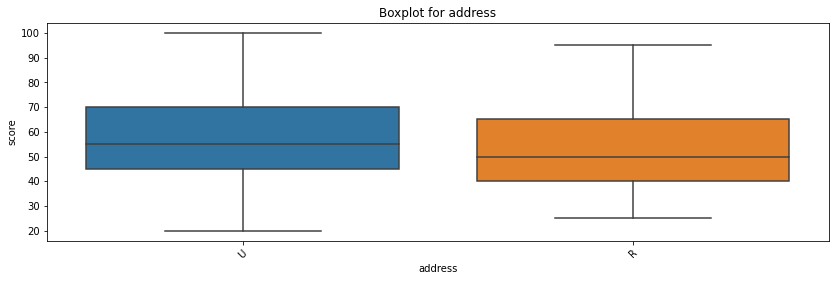

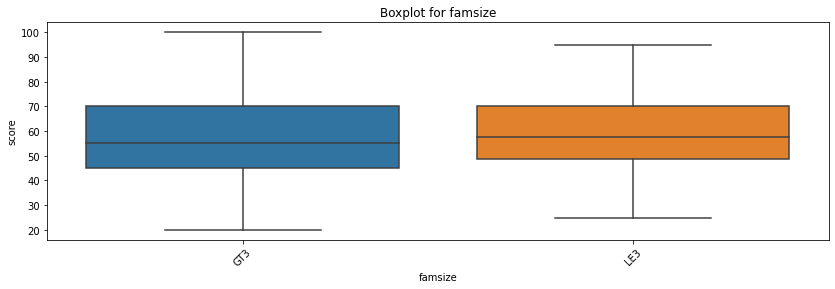

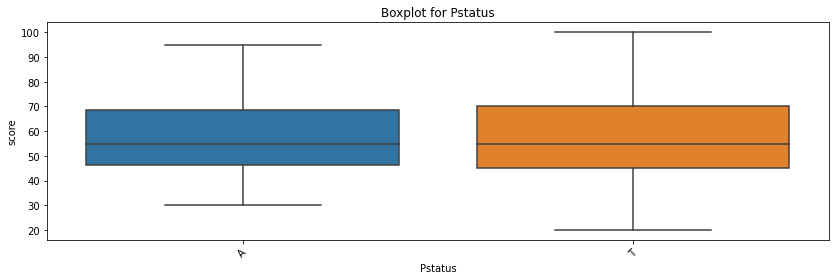

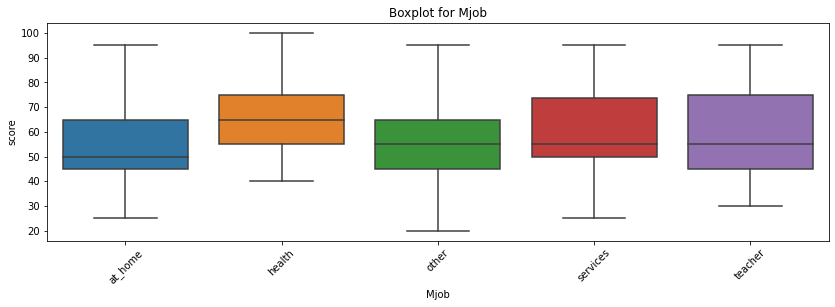

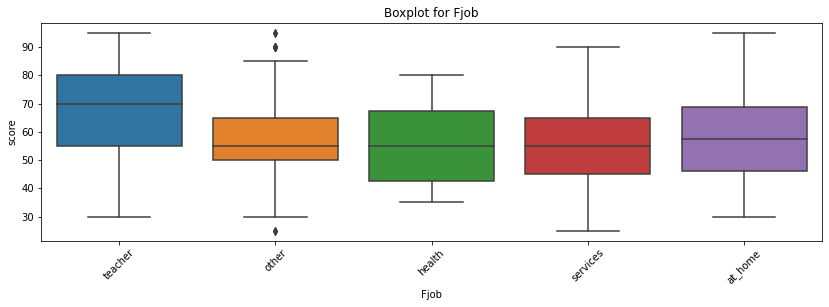

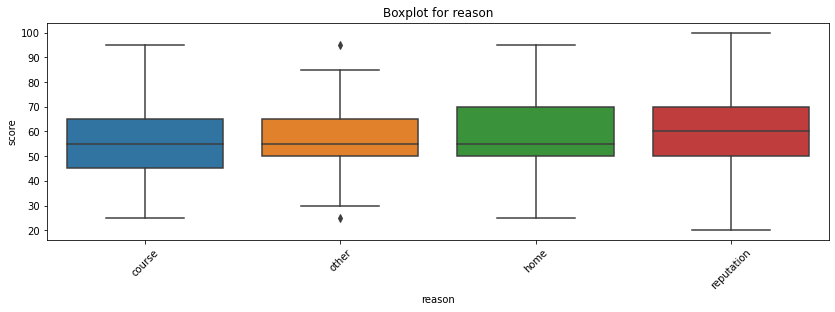

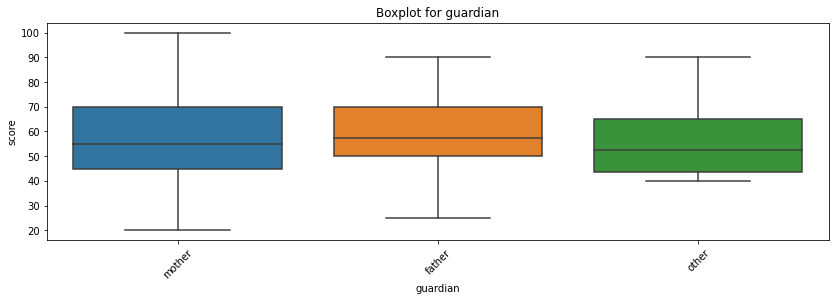

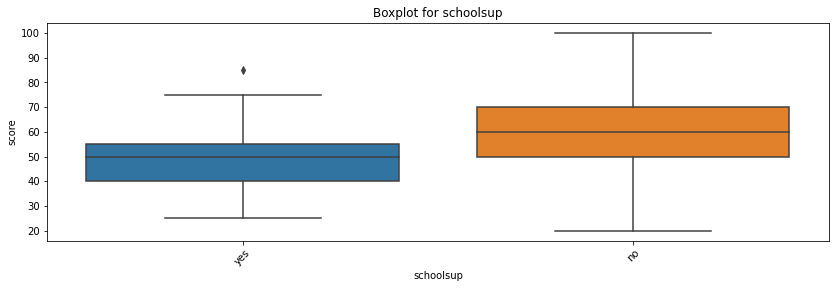

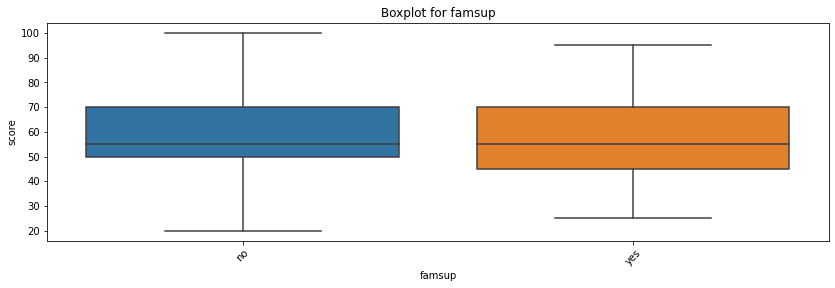

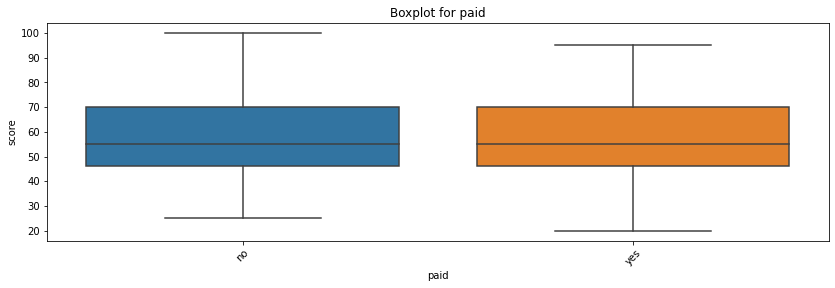

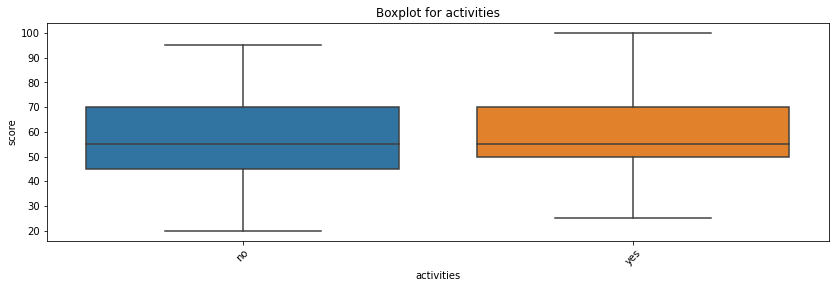

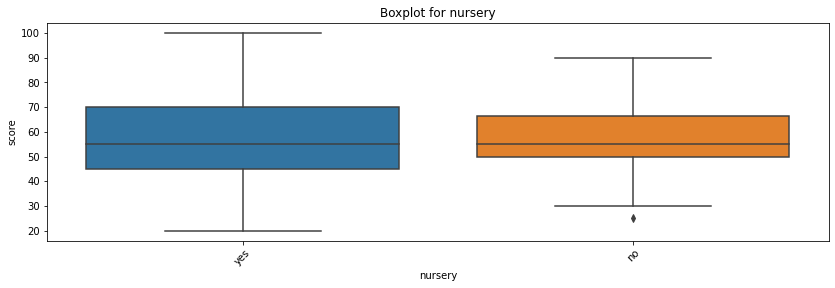

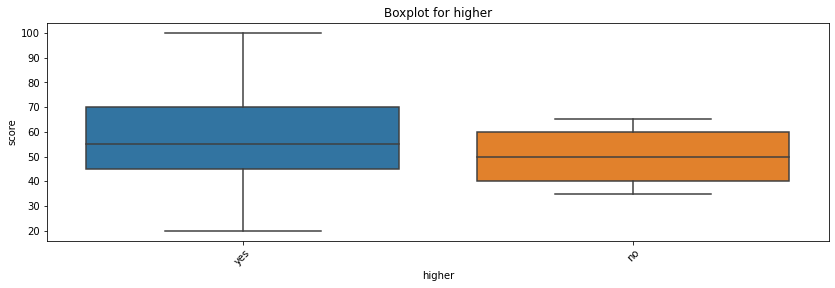

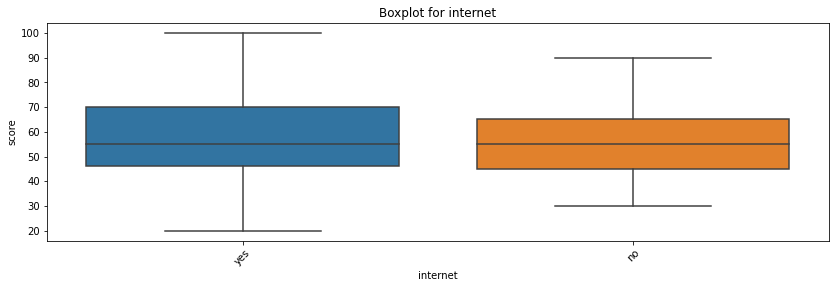

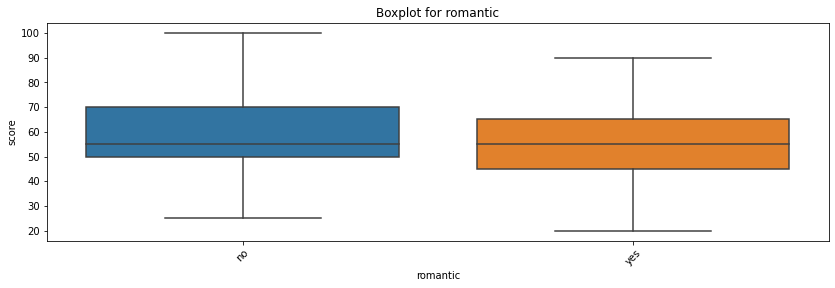

In [21]:
'''Посмотрим, коробочные диаграммы для нечисловых величин.'''


for column in columns_obj:
    get_boxplot(column)

#### Предварительный обзорный анализ:

#### - school: ученики школы GP чуть лучше сдали экзамен по математике, чем ученики школы MS.
#### - sex: мальчики чуть лучше сдали экзамен по математике, чем девочки.
#### - address: городские ребята лучше справились с экзаменом (может быть потому, что меньше уставали в дороге, или потому что хорошие учителя предпочитают работать в городе, где больше платят, или, мб потому что есть больше возможностей для неурочных занятий).
#### - famsize: ребята из более маленьких семей сдали экзамен чуть лучше, чем ребята из больших.
#### - Pstatus: статус совместного проживаня родителей не слишком коррелирует с оценкой за экзамен.
#### - Mjob: ребята, чьи мамы работают в сфере медицины преуспели на экзамене лучше, чем остальные, хуже всего успели ребята, чьи мамы не работают, остальные (учителя, гос.служба и пр) примерно одинаково (интересно, что с параметром health у score обратная корреляция: чем здоровее, чем хуже сдал экзамен).
#### - Fjob: заметно лучше других экзамен сдали ребята, чьи отцы - учителя, на втором месте - дети отцов, сидящих дома, остальные примерно одинаково сдали экзамен.
#### - reason: причины выбора школы почти никак не коррелируют с успехомсдачи экзамена по математике, за исключением выбора школы за её репутацию (здесь успехи школьников немного лучше).
#### - guardian: ребята, чьим опекуном является отец, в среднем немного лучше остальных сдали экзамен по математике, но, кажется, незначительно.
#### - schoolsup: ребята без дополнительной школьной поддержки сдали экзамен значительно лучше тех, кому такая поддержка была оказана (вероятно, её предоставляют в целом более отстающим ученикам).
#### - famsup: семейная образовательная поддержка слабо коррелирует со средней оценкой за экзамен, разве что ребята, с которыми дома не занмаются отдельно, редко получают оценку меньше 50 баллов, в отличие от тех, с кем занимаются.
#### - paid: дополнительные платные занятия по математике статистически практически не дают преимущества в оценке за контрольную (но, опять же, возможно ребята, хорошо разбирающиеся в математике обходятся без доп. платных занятий).
#### - activities: ребята, занятые дополнительной внеучебной активностью редко сдают экзамен хуже 50 баллов, и в этом плане они немного лучше в среднем сдают экзамен, чем те, кто такой активностью не занят, однако медиана в обеих группах примерно на одном уровне.
#### - nursery: посещение детского сада не слишком статистически сказывается на оценку по математике (но в выборке детей, не посещавших сад, значительно меньше, чем тех, кто посещал).
#### - higher: ребята, нацеленные на высшее образование в целом немного лучше сдают математику, чем те, кто не собирается получать его, но там выборка не показательная, почти все хотят получить вышку: 320 против 13-ти.
#### - internet: наличие и отсутствие интернета дома в рамках данного датасета статистически практически не сказывается на оценке заэкзамен по математике. 
#### - romantic: ребята, свободные от романтических отношений в среднем немного лучше сдают экзамен по математике, но не сильно.

In [22]:
'''C помощью теста Стьюдента проверим наличие статистически значимых различий в колонке.'''


for column in columns_obj:
    get_stat_dif(column)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки Fjob
Найдены статистически значимые различия для колонки schoolsup


# Выводы

#### После удаления ошибок и выбросов максимальное количество пустых ячеек в столбце стало 41 из 352.

#### Выбросов было очень мало. Найденные выбросы в столбцах с дискретными значениями (типа "выбери 1 из 4 или 5") вызывают сомнения, поскольку дискретный характер значений довльно сильно влияет на медиану и квартили.

#### Очевидные ошибки были только в столбцах Fedu, famrel и absences. В нечисловых столбцах не было никаких нестрандартных значений, и количество уникальных значений было весьма мало, что позволило строить коробочные диаграммы для каждого уникального значения.

#### Все сильные корреляции довольно очевидны. Положительные корреляции: образованные родители, работающие сферах медицины и образования, большое число внеурочных часов занятий. Отрицательные: пропуски занятий, неудачи в неучебной сфере, продолжительные встречи с друзьями.

#### Не совсем очевидные отрицательные корреляции: здоровье и дополнительные занятия в школе (вероятно, в школе дополнительные занятия проводят с отстающими учениками).

#### Параметры, которые следует использовать в дальнейшем для построения модели:  'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health', 'absences', 'address', 'Mjob', 'Fjob', 'schoolsup'.

In [23]:
'''Датасет для дальнейшего построения модели.'''

data = df[['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime',
           'goout', 'health', 'absences', 'score',  'address', 'Mjob', 'Fjob', 'schoolsup']]